In [1]:
import cv2
import numpy as np

In [ ]:
cap = cv2.VideoCapture('C:/depression videos/Lodhi_Normal.mp4')
cap.get(cv2.CAP_PROP_FRAME_COUNT)

7094.0

In [10]:
cap.get(cv2.CAP_PROP_FPS)

59.8817559012314

In [ ]:
import cv2
import os

# Path to the video file
video_path = 'C:/depression videos/Lodhi_Normal.mp4'

# Directory to save frames
output_dir = 'C:/Depression_Dataset/Depression_Stages/Normal_Frames/Normal'

# Create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Open the video file
cap = cv2.VideoCapture(video_path)

count = 19239

while True:
    ret, frame = cap.read()
    if not ret:
        print('Video ended or frame not found.')
        break
    
    # Save frame as an image file in the "Frame" directory
    cv2.imwrite(os.path.join(output_dir, f'Normal_{count}.jpg'), frame)
    count += 1

# Release the video capture object
cap.release()

print(f"Extracted {count} frames into the folder '{output_dir}'.")




Video ended or frame not found.
Extracted 26333 frames into the folder 'C:/Depression_Dataset/Depression_Stages/Normal_Frames/Normal'.


## Loading the dataset

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os


In [2]:
main_folder = 'Depression_Stages'

batch_size = 16
img_height = 150
img_width = 150

try:
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        main_folder,
        labels='inferred',
        label_mode='int',
        batch_size=batch_size,
        image_size=(img_height, img_width),
        shuffle=True
    )
except ValueError as e:
    print(f"Error: {e}")
    print(f"Directory contents: {os.listdir(main_folder)}")

Found 75447 files belonging to 3 classes.


In [3]:
class_names = dataset.class_names
print(f"Class names: {class_names}")

Class names: ['Moderate_Frames', 'Normal_Frames', 'Severe_Frames']


### Class_names along the lables

In [6]:
# Get the class names and their corresponding labels
class_names = dataset.class_names
print("Class names and their corresponding labels:")
for i, class_name in enumerate(class_names):
    print(f"Label {i}: {class_name}")

Class names and their corresponding labels:
Label 0: Moderate_Frames
Label 1: Normal_Frames
Label 2: Severe_Frames


### Count the number of images in each class

In [7]:
from collections import Counter
# Initialize a Counter to keep track of image counts per class
class_counts = Counter()

# Iterate through the dataset to count images in each class
for _, labels in dataset:
    for label in labels:
        # Convert label to numpy scalar and count it
        class_counts[int(label.numpy())] += 1

# Print the results
for class_label, count in class_counts.items():
    print(f"Class '{class_label}' : {count} images.")

Class '0' : 30349 images.
Class '1' : 26233 images.
Class '2' : 18865 images.


### Plot the loaded images

Class names: ['Moderate_Frames', 'Normal_Frames', 'Severe_Frames']


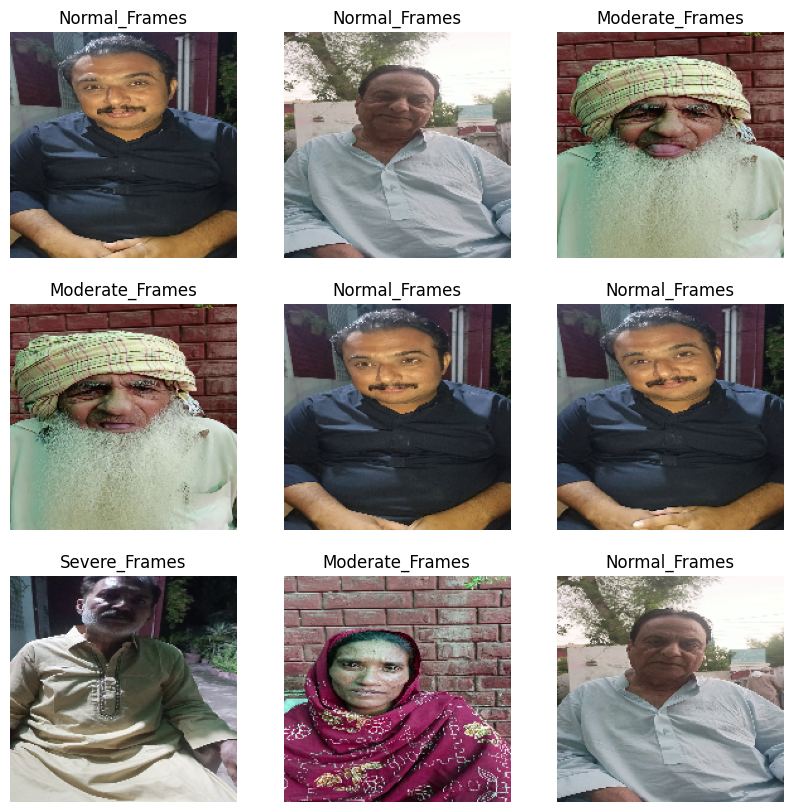

In [ ]:
class_names = dataset.class_names
print(f"Class names: {class_names}")

# Display some images with their labels
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):  # Take one batch for inspection
    for i in range(9):  # Display 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


### Normalize the dataset for further processing

In [8]:
# Normalize pixel values to be between 0 and 1
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

# Apply normalization
dataset = dataset.map(normalize_img)


### Splitting the data into training and validation

In [9]:
# Set 80% of data for training, 20% for validation
training_data = int(0.8 * len(dataset))
val_data = int(0.2 * len(dataset))

In [10]:
train_ds = dataset.take(training_data).take(training_data)
val_ds = dataset.skip(training_data).skip(training_data)


### Count the number of images for training and validation via each frames

In [30]:
# Function to count images in a dataset
def count_images(dataset, class_names):
    total_count = 0
    class_counts = {class_name: 0 for class_name in class_names}
    for images, labels in dataset:
        total_count += images.shape[0]
        for label in labels:
            class_counts[class_names[label.numpy()]] += 1  # Convert label to numpy for indexing
    return total_count, class_counts

# Count images in training and validation sets
train_total, train_class_counts = count_images(train_ds, class_names)
val_total, val_class_counts = count_images(val_ds, class_names)

print("Training Data:")
print(f"  Total images: {train_total}")
print(f"  Class distribution: {train_class_counts}")

print("\nValidation Data:")
print(f"  Total images: {val_total}")
print(f"  Class distribution: {val_class_counts}")

Training Data:
  Total images: 60352
  Class distribution: {'Moderate_Frames': 24298, 'Normal_Frames': 21061, 'Severe_Frames': 14993}

Validation Data:
  Total images: 15088
  Class distribution: {'Moderate_Frames': 6058, 'Normal_Frames': 5165, 'Severe_Frames': 3865}


In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


### Applying the mobile net

In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers,models

In [13]:
# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

C:\Users\Umar Attique\AppData\Local\Temp\ipykernel_12656\2439747733.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


In [14]:
# Freeze the base model to prevent its weights from being updated during training
base_model.trainable = False

In [15]:
# Build the custom model on top of the pre-trained base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  # Adjust this depending on the number of classes
])

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
#Compile the model
model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=1)

1873/3772 ━━━━━━━━━━━━━━━━━━━━ 11:57 378ms/step - accuracy: 0.9986 - loss: 0.0048

In [ ]:
# By using 512 and 128 nodes in dense layer
#3772/3772 ━━━━━━━━━━━━━━━━━━━━ 2206s 583ms/step - accuracy: 0.7534 - loss: 0.5390 - val_accuracy: 0.9965 - val_loss: 0.0316